In [12]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import json

from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

%matplotlib inline

In [ ]:
class_name2idx_dict = {
    'Unlabeled': 0,
    'Buildings': 1,
    'Applicable Ground': 2,
    'Applicable Grow': 3,
    'Applicable Wetland': 4,
    'Applicable Wood': 5,
    'Non-Applicable Ground': 6,
    'Non-Applicable Grow': 7,
    'Non-Applicable Wetland': 8,
    'Transport': 9,
    'Water': 10
}

class_idx2name_dict = {v:k for k, v in class_name2idx_dict.items()}

class_idx2color_dict = {
    0: '#000000', # 'Unlabeled'
    1: "#616161", # 'Buildings'
    2: "#fce300", # 'Applicable Ground'
    3: '#73ef35', # 'Applicable Grow'
    4: "#474D26", # 'Applicable Wetland'
    5: '#549b52', # 'Applicable Wood'
    6: "#F5F3A1", # 'Non-Applicable Ground'
    7: "#03ca03", # 'Non-Applicable Grow'
    8: '#8d854e', # 'Non-Applicable Wetland'
    9: "#CCCCCC", # 'Transport'
    10: '#5989e1' # 'Water'
}



{0: 'Unlabeled',
 1: 'Buildings',
 2: 'Applicable Ground',
 3: 'Applicable Grow',
 4: 'Applicable Wetland',
 5: 'Applicable Wood',
 6: 'Non-Applicable Ground',
 7: 'Non-Applicable Grow',
 8: 'Non-Applicable Wetland',
 9: 'Transport',
 10: 'Water'}

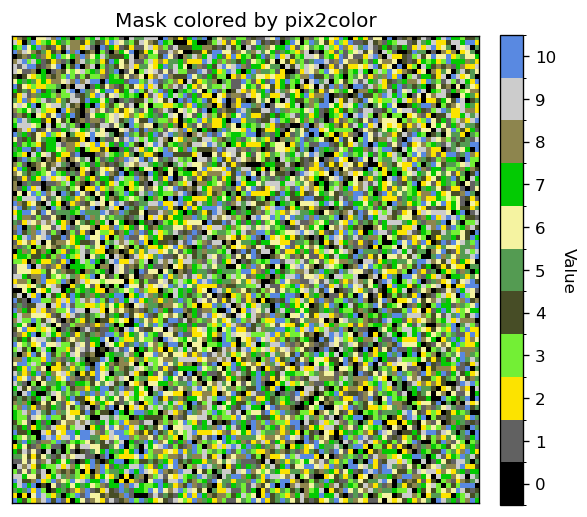

In [11]:


# Предполагается, что у вас уже есть:
# mask: np.ndarray формы (96, 96) с int значениями
# pix2color: dict вида {int_value: "#RRGGBB"}
pix2color = {
    0: '#000000', # 'Unlabeled'
    1: "#616161", # 'Buildings'
    2: "#fce300", # 'Applicable Ground'
    3: '#73ef35', # 'Applicable Grow'
    4: "#474D26", # 'Applicable Wetland'
    5: '#549b52', # 'Applicable Wood'
    6: "#F5F3A1", # 'Non-Applicable Ground'
    7: "#03ca03", # 'Non-Applicable Grow'
    8: '#8d854e', # 'Non-Applicable Wetland'
    9: "#CCCCCC", # 'Transport'
    10: '#5989e1' # 'Water'
}

mask = np.random.randint(0, 11, size=(96,96))


# 1) Проверим, что все значения в mask имеют цвет
vals_in_mask = np.unique(mask)
missing = [v for v in vals_in_mask if v not in pix2color]
if missing:
    raise ValueError(f"Для значений {missing} нет цветов в pix2color")

# 2) Отсортированный список дискретных значений и соответствующие цвета
values = sorted(pix2color.keys())
colors = [pix2color[v] for v in values]

# 3) Дискретная карта цветов и нормировка по «коробкам» вокруг целых
cmap = ListedColormap(colors, name="pixmap", N=len(colors))

# Границы по центрам между соседними целыми: [v0-0.5, v0+0.5, v1+0.5, ...]
boundaries = np.array(values, dtype=float)
boundaries = np.concatenate(([boundaries[0] - 0.5], (boundaries[:-1] + boundaries[1:]) / 2, [boundaries[-1] + 0.5]))
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

# 4) Отрисовка
fig, ax = plt.subplots(figsize=(5, 5), dpi=120)
im = ax.imshow(mask, cmap=cmap, norm=norm, interpolation="nearest")
ax.set_title("Mask colored by pix2color")
ax.set_xticks([])
ax.set_yticks([])

# 5) Дискретный colorbar с метками именно ваших значений
cbar = plt.colorbar(im, ax=ax, ticks=values, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Value", rotation=270, labelpad=12)

plt.tight_layout()
plt.show()

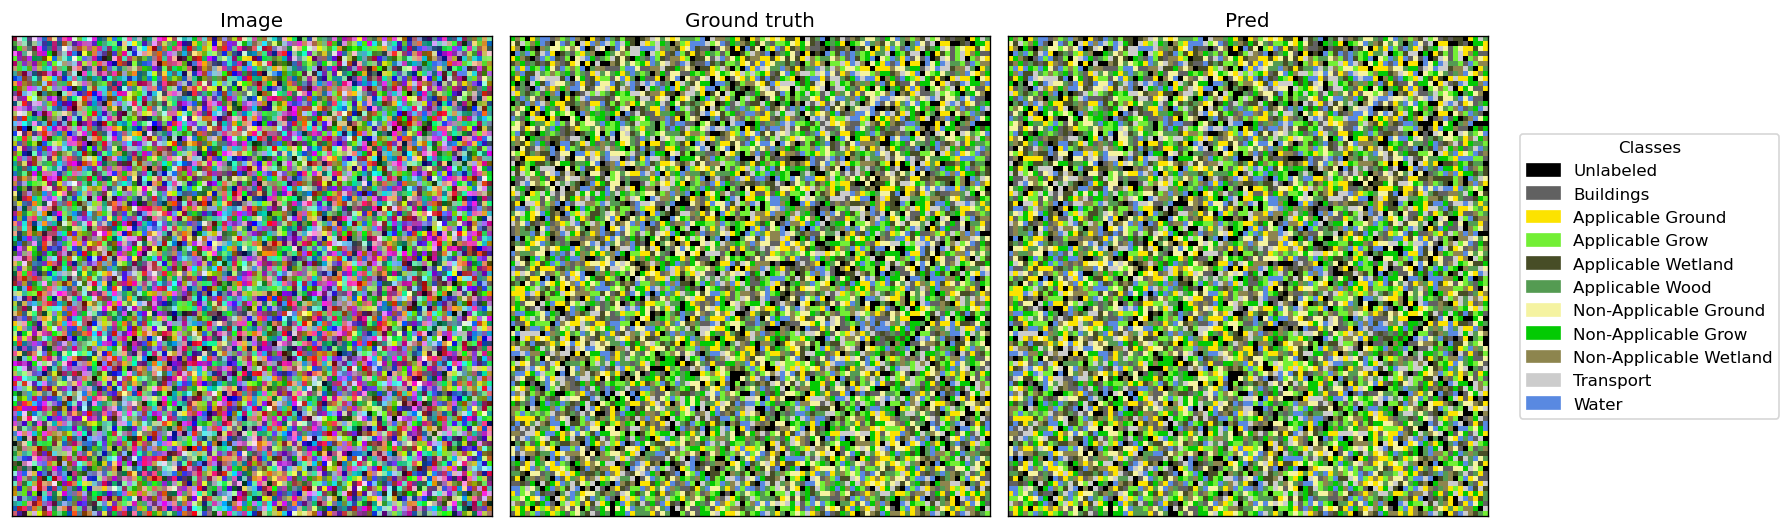

In [17]:
pix2class = {
    0: 'Unlabeled',
 1: 'Buildings',
 2: 'Applicable Ground',
 3: 'Applicable Grow',
 4: 'Applicable Wetland',
 5: 'Applicable Wood',
 6: 'Non-Applicable Ground',
 7: 'Non-Applicable Grow',
 8: 'Non-Applicable Wetland',
 9: 'Transport',
 10: 'Water'}

pix2color = {
    0: '#000000', # 'Unlabeled'
    1: "#616161", # 'Buildings'
    2: "#fce300", # 'Applicable Ground'
    3: '#73ef35', # 'Applicable Grow'
    4: "#474D26", # 'Applicable Wetland'
    5: '#549b52', # 'Applicable Wood'
    6: "#F5F3A1", # 'Non-Applicable Ground'
    7: "#03ca03", # 'Non-Applicable Grow'
    8: '#8d854e', # 'Non-Applicable Wetland'
    9: "#CCCCCC", # 'Transport'
    10: '#5989e1' # 'Water'
}
img = np.random.randint(0, 65536, size=(96,96,3))/65536
mask = np.random.randint(0, 11, size=(96,96))
gt_mask = np.random.randint(0, 11, size=(96,96))

vals_in_mask = np.unique(mask)
missing = [v for v in vals_in_mask if v not in pix2color]
if missing:
    raise ValueError(f"Нет цветов для значений: {missing}")

# Сортируем значения
values = sorted(pix2color.keys())
colors = [pix2color[v] for v in values]

# Создаём дискретную cmap и norm
cmap = ListedColormap(colors, name="pixmap", N=len(colors))
boundaries = np.array(values, dtype=float)
boundaries = np.concatenate((
    [boundaries[0] - 0.5],
    (boundaries[:-1] + boundaries[1:]) / 2,
    [boundaries[-1] + 0.5]
))
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

# Рисуем маску
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 9), dpi=120)
im = axs[0].imshow(img)
axs[0].set_title("Image")
axs[0].set_xticks([])
axs[0].set_yticks([])

im = axs[1].imshow(gt_mask, cmap=cmap, norm=norm, interpolation="nearest")
axs[1].set_title("Ground truth")
axs[1].set_xticks([])
axs[1].set_yticks([])

im = axs[2].imshow(gt_mask, cmap=cmap, norm=norm, interpolation="nearest")
axs[2].set_title("Pred")
axs[2].set_xticks([])
axs[2].set_yticks([])

# Формируем список патчей для легенды
patches = [
    mpatches.Patch(color=pix2color[val], label=pix2class.get(val, str(val)))
    for val in values if val in vals_in_mask
]

# Добавляем легенду сбоку
axs[2].legend(
    handles=patches,
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    title="Classes"
)

plt.tight_layout()
plt.show()